In [2]:
import numpy as np
from neo import io
from natsort import natsorted
from utils import *
from glob import glob
import pandas as pd
import seaborn as sns

Read ECoG data, organise them into a dataframe

In [4]:
# read ecog data and organize according to channel map
data = natsorted(glob('data/w12_18_spont/lfp*.ibw'))
files = [d for d in data if int(d.split('/')[-1].split('.')[0].split('p')[-1]) <= 64] # only use first 64 channels
data = [load_ibw_data(f) for f in files] # load data 
times = data[0].times # get time vector
data = [np.squeeze(d.magnitude) for d in data] 
# define channel map
channel_map = np.array([[49,50,51,52,59,58,57,56,55,54,53],
                        [60,61,62,63,54,43,44,45,46,47,65],
                        [42,41,40,39,38,33,34,35,36,37,65],
                        [26,25,24,23,22,17,18,19,20,21,65],
                        [12,13,14,15,16,27,28,29,30,31,65],
                        [1,2,3,4,11,10,9,8,7,6,5]])
ecog_data = np.array(data) # convert to numpy array
ecog_data.shape

(64, 1567540)

In [6]:
# calculate mean of data
mean_data = np.mean(ecog_data, axis=0)
# calculate 95% confidence interval for each point
ci = np.zeros((2, len(times)))
for i in range(len(times)):
    ci[:,i] = np.percentile(ecog_data[:,i], [2.5, 97.5])

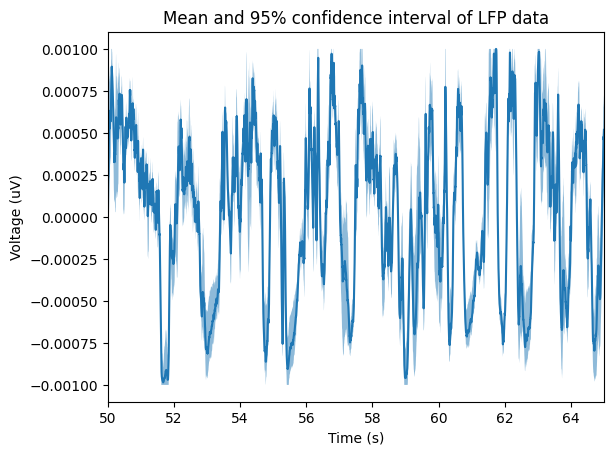

In [7]:
plt.plot(times, mean_data) # plot mean
plt.fill_between(times, ci[0,:], ci[1,:], alpha=0.5) # fill between 95% confidence interval

plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Mean and 95% confidence interval of LFP data') 

plt.xlim([50, 65]) # zoom in on a specific time interval
plt.show()

In [37]:
# remove warning messages
import warnings
warnings.filterwarnings('ignore')

spikes_data_paths = natsorted(glob('data/spiking_data/*.txt')) # read spiking data
spikes_control_data_paths = natsorted(glob('data/spiking_data_control/*.txt')) # read spiking data for control condition

channels = []
spikes_data = {}
spikes_control_data = {}

for spikes_data_path, spikes_control_data_path in zip(spikes_data_paths, spikes_control_data_paths): 
    channel = str(spikes_data_path.split('/')[-1].split('.')[0].split('_')[0])
    channels.append(channel) # get channel number

    spikes = np.loadtxt(spikes_data_path, dtype=object) # load data
    spikes_control = np.loadtxt(spikes_control_data_path, dtype=object)

    spikes = [s for i,s in enumerate(spikes) if i%2==0]
    spikes_control = [s for i,s in enumerate(spikes_control) if i%2==0]

    spikes = np.array(spikes, dtype=float)
    spikes_control = np.array(spikes_control, dtype=float)

    spikes_data[channel] = spikes
    spikes_control_data[channel] = spikes_control

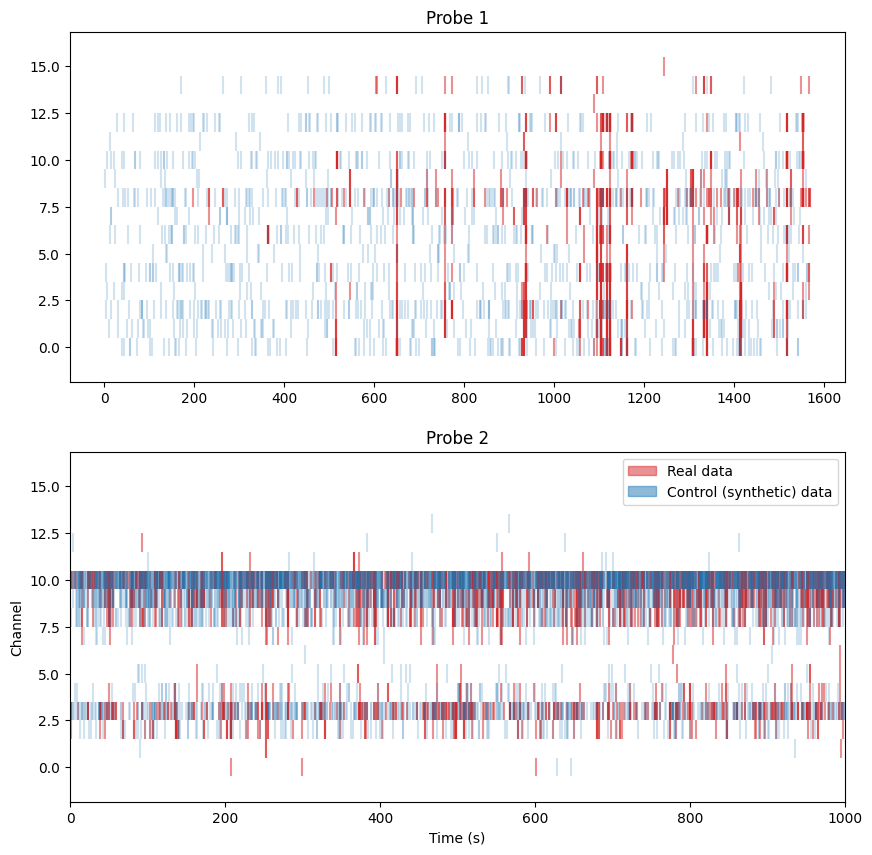

In [42]:
import matplotlib.patches as mpatches
# plot spiking data separately for 1st and 2nd probe
probe1 = [str(i) for i in range(65,81)]
probe2 = [str(i) for i in range(97,113)]

probe1_channels = [f'csc{c}' for c in probe1]
probe2_channels = [f'csc{c}' for c in probe2]

fig, ax = plt.subplots(2,1, figsize=(10,10))

# get all values for probe1_channels
spikes = [spikes_data[c] for c in probe1_channels]
spikes_control = [spikes_control_data[c] for c in probe1_channels]
ax[0].eventplot(spikes, color='tab:red',linelengths=1, alpha = 0.5)
ax[0].eventplot(spikes_control, color='tab:blue',linelengths=1, alpha = 0.2)
# add title
ax[0].set_title('Probe 1')


# get all values for probe2_channels
spikes = [spikes_data[c] for c in probe2_channels]
spikes_control = [spikes_control_data[c] for c in probe2_channels]
ax[1].eventplot(spikes, color='tab:red',linelengths=1, alpha = 0.5)
ax[1].eventplot(spikes_control, color='tab:blue',linelengths=1, alpha = 0.2)
# add title
ax[1].set_title('Probe 2')

red_patch = mpatches.Patch(color='tab:red', alpha=0.5, label='Real data')
blue_patch = mpatches.Patch(color='tab:blue',alpha=0.5, label='Control (synthetic) data')
plt.legend(handles=[red_patch, blue_patch])
plt.xlim([0, 1000])

plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.show()

In [73]:
# calculate upstate/downstate bins
event_times, th = define_upstate_regions(data, times, threshold_scalar=1, binning_size=10, plot=False)

(1567540,) [ 0.  0.  0. ... 64. 64. 64.]
(1109318,)
[0.000000e+00 1.000000e-03 2.000000e-03 ... 1.567315e+03 1.567316e+03
 1.567317e+03] s


100%|██████████| 1109317/1109317 [00:00<00:00, 2196532.02it/s]


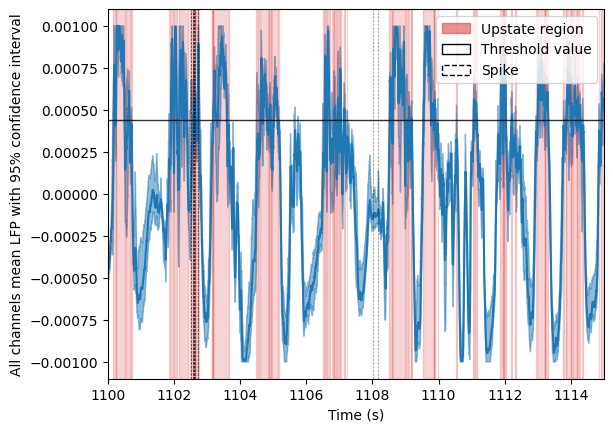

In [74]:
# plot regions
plt.plot(times, mean_data, color='tab:blue') # plot mean
plt.fill_between(times, ci[0,:], ci[1,:], alpha=0.5, color='tab:blue') # fill between 95% confidence interval
# show th
plt.axhline(th, color='k', linewidth=1, alpha=0.8)

for i in range(len(spikes_data['csc65'])):
    plt.axvline(x=spikes_data['csc65'][i], color='k', linestyle='--', linewidth=0.5, alpha=0.5)
for event in event_times:
    plt.axvspan(event[0], event[1], alpha=0.2, color='tab:red', label='Upstate regions')

red_patch = mpatches.Patch(color='tab:red', alpha=0.5, label='Upstate region')
black_patch = mpatches.Patch(linestyle='-', color='k',alpha=1, label='Threshold value', fill=False)
dashed_patch = mpatches.Patch(linestyle='--', color='k',alpha=1, label='Spike', fill=False)
plt.legend(handles=[red_patch, black_patch, dashed_patch])

plt.xlim([1100, 1115])
plt.xlabel('Time (s)')
plt.ylabel('All channels mean LFP with 95% confidence interval')
# plt.title('Spiking data')
# plt.legend()
plt.show()

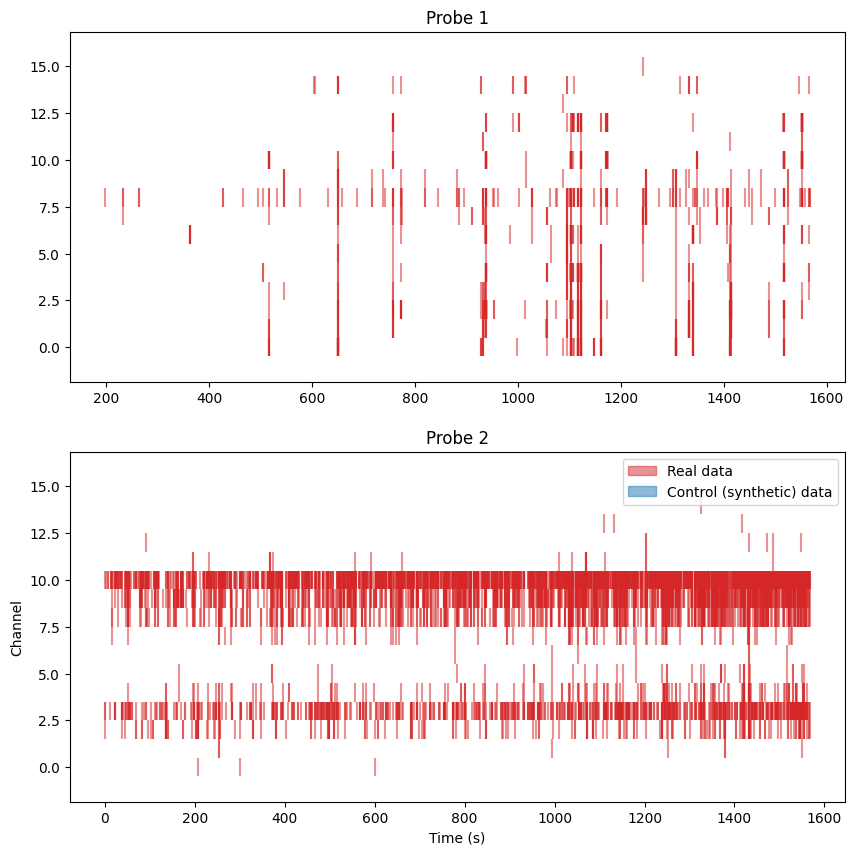

In [79]:
import matplotlib.patches as mpatches
# plot spiking data separately for 1st and 2nd probe
probe1 = [str(i) for i in range(65,81)]
probe2 = [str(i) for i in range(97,113)]

probe1_channels = [f'csc{c}' for c in probe1]
probe2_channels = [f'csc{c}' for c in probe2]

fig, ax = plt.subplots(2,1, figsize=(10,10))

# get all values for probe1_channels
spikes = [spikes_data[c] for c in probe1_channels]
spikes_control = [spikes_control_data[c] for c in probe1_channels]
ax[0].eventplot(spikes, color='tab:red',linelengths=1, alpha = 0.5)
# ax[0].eventplot(spikes_control, color='tab:blue',linelengths=1, alpha = 0.2)
# add title
ax[0].set_title('Probe 1')

# for event in event_times:
#     ax[0].axvspan(event[0], event[1], alpha=0.05, color='grey', label='Upstate regions')
# plt.xlim([0, 300])

# get all values for probe2_channels
spikes = [spikes_data[c] for c in probe2_channels]
spikes_control = [spikes_control_data[c] for c in probe2_channels]
ax[1].eventplot(spikes, color='tab:red',linelengths=1, alpha = 0.5)
# ax[1].eventplot(spikes_control, color='tab:blue',linelengths=1, alpha = 0.2)
# add title
ax[1].set_title('Probe 2')

# for event in event_times:
#     ax[1].axvspan(event[0], event[1], alpha=0.05, color='grey', label='Upstate regions')

red_patch = mpatches.Patch(color='tab:red', alpha=0.5, label='Real data')
blue_patch = mpatches.Patch(color='tab:blue',alpha=0.5, label='Control (synthetic) data')
plt.legend(handles=[red_patch, blue_patch])
# plt.xlim([0, 50])

plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.show()

In [76]:
# get only spikes that lay inside the event times
upstate_spikes_n = []
all_spikes_n = []
upstate_spikes_n_probe2 = []
all_spikes_n_probe_2 = []
upstate_spikes_control_n = []
all_spikes_control_n = []

ch_n_probe1 = []
ch_n_probe2 = []
ch_n_control = []
channels = list(spikes_data.keys())
for channel in channels:
    # get channel number
    channel_number = int(str(channel).split('csc')[1])
    spike_data = spikes_data[channel]
    upstate_spikes = []
    for event in event_times:
        spikes_upstate = spike_data[(spike_data > event[0]) & (spike_data < event[1])]
        upstate_spikes.extend(spikes_upstate)
    if channel_number <= 80:
        upstate_spikes_n.append(len(upstate_spikes))
        all_spikes_n.append(len(spike_data))
        ch_n_probe1.append((channel_number - 65) * 100)

        # do same for control data
        spike_data = spikes_control_data[channel]
        upstate_spikes = []
        for event in event_times:
            spikes_upstate = spike_data[(spike_data > event[0]) & (spike_data < event[1])]
            upstate_spikes.extend(spikes_upstate)
        upstate_spikes_control_n.append(len(upstate_spikes))
        all_spikes_control_n.append(len(spike_data))
        ch_n_control.append(0)
    else:
        upstate_spikes_n_probe2.append(len(upstate_spikes))
        all_spikes_n_probe_2.append(len(spike_data))
        ch_n_probe2.append((channel_number-97)*100)

# print(np.divide(upstate_spikes_n,all_spikes_n))
# print(np.divide(upstate_spikes_control_n,all_spikes_control_n))

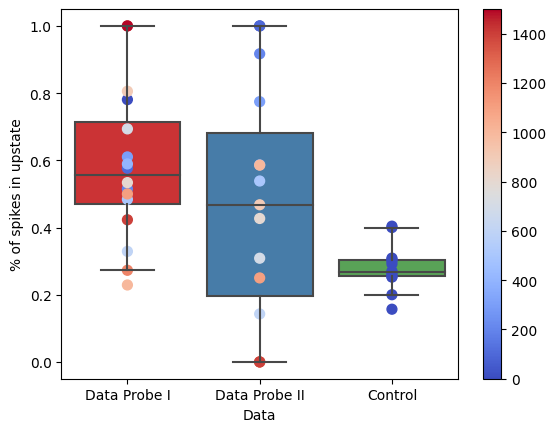

t = nan
p = nan


In [77]:
import scipy.stats as stats

wd_per = np.divide(upstate_spikes_n,all_spikes_n)
wd_per_2 = np.divide(upstate_spikes_n_probe2, all_spikes_n_probe_2)
control_per = np.divide(upstate_spikes_control_n,all_spikes_control_n)

# make pandas dataframe 
df = pd.DataFrame({'Data Probe I': wd_per, 'Data Probe II': wd_per_2, 'Control': control_per})
df = pd.melt(df)
# define column names
df.columns = ['Data', '% of spikes in upstate']
df['Depth'] = ch_n_probe1 + ch_n_probe2 + ch_n_control

# plot two boxplots
sns.boxplot(x='Data', y='% of spikes in upstate', data=df, whis=[5,95], showfliers=False, palette='Set1')
# sns.swarmplot(x='Data', y='% of spikes in upstate', data=df, alpha=1, hue='Depth', palette='Set2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# instead of labels use continuous color scale
plt.scatter(x='Data', y='% of spikes in upstate', data=df, alpha=1, c=df['Depth'], cmap='coolwarm', s=50)
# create colorbar
plt.colorbar()
plt.show()
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# ax.boxplot([wd_per, control_per], labels=['true data', 'synthetic data'], showfliers=False, whis=[5,95], widths=0.5, patch_artist=True)
# # show also scatter for both groups
# ax.plot(np.ones(len(wd_per)), wd_per, 'o', color='k', alpha=0.5)
# ax.plot(2*np.ones(len(control_per)), control_per, 'o', color='k', alpha=0.5)

# plt.show()
# test for significance
t, p = stats.ttest_ind(wd_per, control_per)
print('t = ' + str(t))
print('p = ' + str(p))

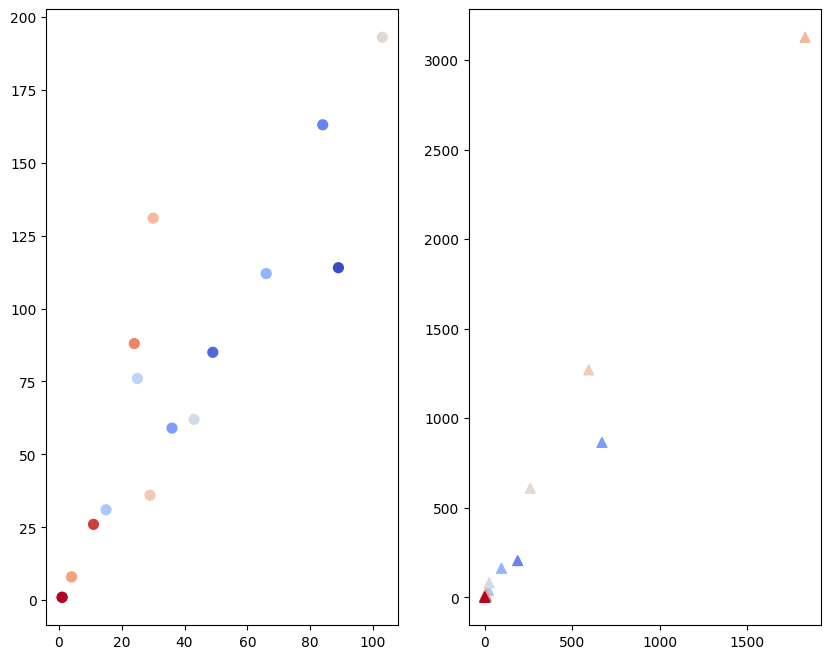

In [78]:
import scipy.stats as stats

# wd_per = np.divide(upstate_spikes_n,all_spikes_n)
# wd_per_2 = np.divide(upstate_spikes_n_probe2, all_spikes_n_probe_2)
# control_per = np.divide(upstate_spikes_control_n,all_spikes_control_n)

# make pandas dataframe 
# df = pd.DataFrame({'Data Probe I': wd_per, 'Data Probe II': wd_per_2, 'Control': control_per})
# df = pd.melt(df)
# # define column names
# df.columns = ['Data', '% of spikes in upstate']
# df['Depth'] = ch_n_probe1 + ch_n_probe2 + ch_n_control
# remove max value from upstate_spikes_n_probe2
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

# plot two boxplots
ax[0].scatter(x=upstate_spikes_n, y=all_spikes_n, alpha=1, c=ch_n_probe1, cmap='coolwarm', s=50, label='Probe I')
ax[1].scatter(x=upstate_spikes_n_probe2, y=all_spikes_n_probe_2, alpha=1, c=ch_n_probe2, cmap='coolwarm', s=50, marker='^', label='Probe II')
# use same color scale for second probe but different symbol
# plt.scatter(x=upstate_spikes_n_probe2, y=all_spikes_n_probe_2, alpha=1, c=ch_n_probe2, cmap='coolwarm', s=50, marker='^', label='Probe II')
# sns.swarmplot(x='Data', y='% of spikes in upstate', data=df, alpha=1, hue='Depth', palette='Set2')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# instead of labels use continuous color scale
# plt.scatter(x='Data', y='% of spikes in upstate', data=df, alpha=1, c=df['Depth'], cmap='coolwarm', s=50)
# create colorbar
# plt.colorbar()

plt.show()

# plt.show()
# test for significance
# t, p = stats.ttest_ind(wd_per, control_per)
# print('t = ' + str(t))
# print('p = ' + str(p))

In [8]:
# read electrode data and organize according to channel map
data = natsorted(glob('data/w12_18_spont/lfp*.ibw'))
files = [d for d in data if int(d.split('/')[-1].split('.')[0].split('p')[-1]) >= 65] # only use first 64 channels
data = [load_ibw_data(f) for f in files] # load data 
times = data[0].times # get time vector
data = [np.squeeze(d.magnitude) for d in data] 
# define channel map
electrode_data = np.array(data) # convert to numpy array
electrode_data.shape

(32, 1567540)

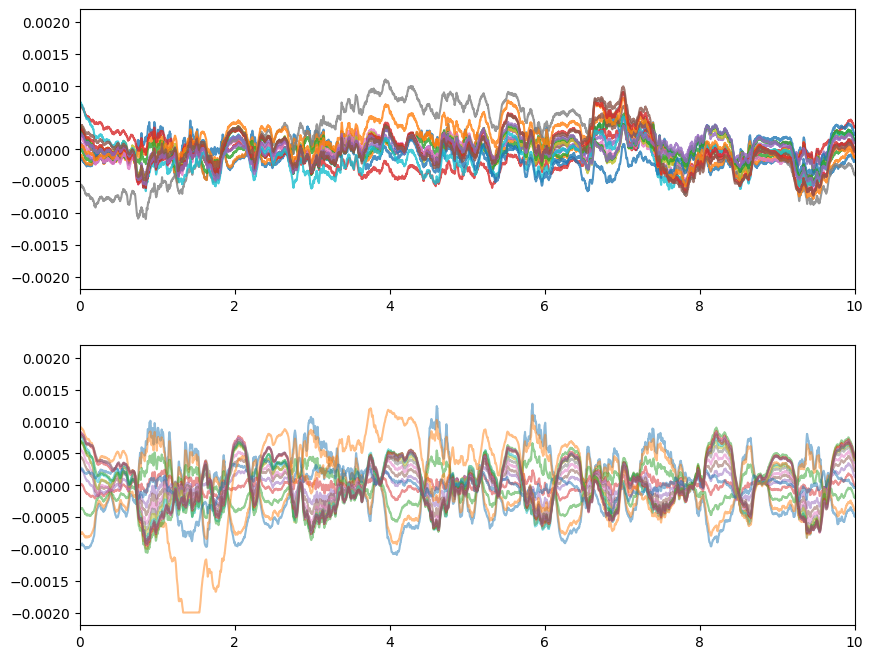

In [21]:
# plot electrode data, all channels
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
for ch in range(electrode_data.shape[0])[:16]:
    ax[0].plot(times, electrode_data[ch, :], alpha=0.8)
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Voltage (mV)')
# # set limits
ax[0].set_xlim([0, 10])

# plot electrode data, all channels
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for ch in range(electrode_data.shape[0])[16:]:
    ax[1].plot(times, electrode_data[ch, :], alpha=0.5)
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Voltage (mV)')
# set limits
# ax[1].set_xlim([0, 10])
ax[1].set_xlim([0, 10])
plt.show()

In [23]:
# calculate mean of data
mean_electrode_data = np.mean(electrode_data, axis=0)
# calculate 95% confidence interval for each point
ci_el = np.zeros((2, len(times)))
for i in range(len(times)):
    ci_el[:,i] = np.percentile(electrode_data[:,i], [2.5, 97.5])

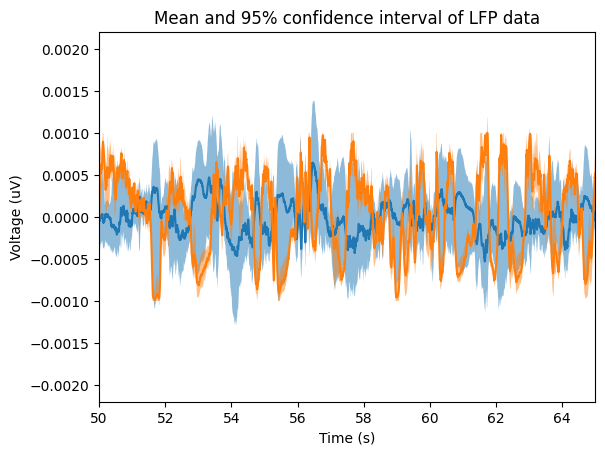

In [25]:
plt.plot(times, mean_electrode_data) # plot mean
plt.fill_between(times, ci_el[0,:], ci_el[1,:], alpha=0.5) # fill between 95% confidence interval

plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Mean and 95% confidence interval of LFP data') 

plt.xlim([50, 65]) # zoom in on a specific time interval

plt.plot(times, mean_data) # plot mean
plt.fill_between(times, ci[0,:], ci[1,:], alpha=0.5) # fill between 95% confidence interval

# plt.xlabel('Time (s)')
# plt.ylabel('Voltage (uV)')
# plt.title('Mean and 95% confidence interval of LFP data') 

plt.xlim([50, 65]) # zoom in on a specific time interval
plt.show()

plt.show()

In [43]:
# calculate upstate/downstate bins
event_times = define_upstate_regions(data, times, threshold_scalar=1.5, binning_size=10, plot=False)

(1567540,) [12. 12. 11. ...  7.  6.  5.]
(1019076,)
[1.740000e-01 1.750000e-01 1.760000e-01 ... 1.567333e+03 1.567334e+03
 1.567335e+03] s


100%|██████████| 1019075/1019075 [00:00<00:00, 2002257.11it/s]


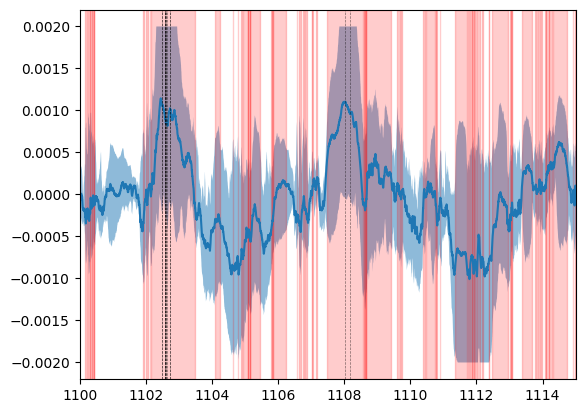

In [44]:
# plot regions
plt.plot(times, mean_data) # plot mean
plt.fill_between(times, ci[0,:], ci[1,:], alpha=0.5) # fill between 95% confidence interval

for i in range(len(spikes_data['csc65'])):
    plt.axvline(x=spikes_data['csc65'][i], color='k', linestyle='--', linewidth=0.5, alpha=0.5)
for event in event_times:
    plt.axvspan(event[0], event[1], alpha=0.2, color='red')

plt.xlim([1100, 1115])
plt.show()

In [45]:
# get only spikes that lay inside the event times
upstate_spikes_n = []
all_spikes_n = []

upstate_spikes_control_n = []
all_spikes_control_n = []

for channel in channels:
    spike_data = spikes_data[channel]
    upstate_spikes = []
    for event in event_times:
        spikes_upstate = spike_data[(spike_data > event[0]) & (spike_data < event[1])]
        upstate_spikes.extend(spikes_upstate)
    upstate_spikes_n.append(len(upstate_spikes))
    all_spikes_n.append(len(spike_data))

    # do same for control data
    spike_data = spikes_control_data[channel]
    upstate_spikes = []
    for event in event_times:
        spikes_upstate = spike_data[(spike_data > event[0]) & (spike_data < event[1])]
        upstate_spikes.extend(spikes_upstate)
    upstate_spikes_control_n.append(len(upstate_spikes))
    all_spikes_control_n.append(len(spike_data))


print(np.divide(upstate_spikes_n,all_spikes_n))
print(np.divide(upstate_spikes_control_n,all_spikes_control_n))


[1.         1.         1.         1.         1.         1.
 1.         0.96774194 0.88082902 0.83333333 1.         1.
 1.         1.         1.         1.         1.         1.
 0.75121951 0.58959538 0.50617284 0.53846154 0.57142857 0.41975309
 0.28571429 0.31023622 0.3887468  0.55       0.         0.33333333
 1.                nan]
[0.39814815 0.37373737 0.36746988 0.29411765 0.26956522 0.48571429
 0.26262626 0.32835821 0.35028249 0.23333333 0.39837398 0.4
 0.38834951        nan 0.33333333        nan 0.5        0.25
 0.27319588 0.35023585 0.32596685 0.34090909 0.4        0.35802469
 0.38275862 0.36698718 0.35123322 0.4        0.09090909 0.33333333
        nan        nan]


/var/folders/gw/9m0zb5rx7vv69h7z1804vcc00000gn/T/ipykernel_43913/3658927705.py:27: RuntimeWarning: invalid value encountered in divide
  print(np.divide(upstate_spikes_n,all_spikes_n))
/var/folders/gw/9m0zb5rx7vv69h7z1804vcc00000gn/T/ipykernel_43913/3658927705.py:28: RuntimeWarning: invalid value encountered in divide
  print(np.divide(upstate_spikes_control_n,all_spikes_control_n))


/var/folders/gw/9m0zb5rx7vv69h7z1804vcc00000gn/T/ipykernel_43913/1421440130.py:3: RuntimeWarning: invalid value encountered in divide
  wd_per = np.divide(upstate_spikes_n,all_spikes_n)
/var/folders/gw/9m0zb5rx7vv69h7z1804vcc00000gn/T/ipykernel_43913/1421440130.py:4: RuntimeWarning: invalid value encountered in divide
  control_per = np.divide(upstate_spikes_control_n,all_spikes_control_n)


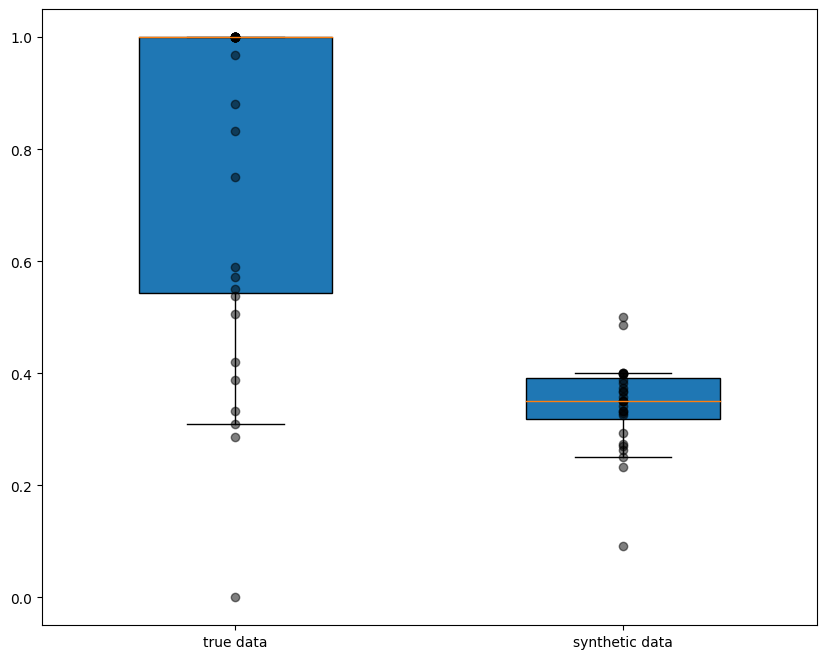

t = 7.400566239391818
p = 6.838731823469327e-10


In [46]:
import scipy.stats as stats

wd_per = np.divide(upstate_spikes_n,all_spikes_n)
control_per = np.divide(upstate_spikes_control_n,all_spikes_control_n)

# remove nan values
wd_per = wd_per[~np.isnan(wd_per)]
control_per = control_per[~np.isnan(control_per)]

# plot two boxplots
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.boxplot([wd_per, control_per], labels=['true data', 'synthetic data'], showfliers=False, whis=[5,95], widths=0.5, patch_artist=True)
# show also scatter for both groups
ax.plot(np.ones(len(wd_per)), wd_per, 'o', color='k', alpha=0.5)
ax.plot(2*np.ones(len(control_per)), control_per, 'o', color='k', alpha=0.5)

plt.show()
# test for significance
t, p = stats.ttest_ind(wd_per, control_per)
print('t = ' + str(t))
print('p = ' + str(p))